<center><img src="https://ingenieria2.udea.edu.co/gepp/assets/logo-ingenieria-udea.svg"></center>

**Tratamiento de Señales III**

*Presentado por:*

*Luis alberto Ochoa M.*

*Jhon James Tapie P.*

*Prof. Hernán Felipe García Arias.*

**Facultad de Ingeniería**

**Universidad de Antioquia**

2023-1

# Librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
import ipywidgets as widgets
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

### Lectura de los datos

In [2]:
!wget "https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM.csv" -O "df.csv"
!wget "https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM_test.csv" -O "df_test.csv"

--2023-06-08 12:28:34--  https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 609574 (595K) [text/plain]
Saving to: ‘df.csv’

df.csv              100%[===================>] 595.29K  --.-KB/s    in 0.04s   

2023-06-08 12:28:35 (13.5 MB/s) - ‘df.csv’ saved [609574/609574]

--2023-06-08 12:28:35--  https://raw.githubusercontent.com/LuisOchoaM/Proyecto_Final_TS3/main/Dataset_16QAM_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307156 (300K) [t

In [3]:
df_test = pd.read_csv('df_test.csv')
url_training = 'https://drive.google.com/uc?id=1fXHJVAI4cijBs97gvPVnddsORWBCwSAQ'
signal = pd.read_csv(url_training,sep=';',index_col=0)
df = pd.DataFrame(signal)
df

,Real,Imaginario,Map
SNR,,,
-10,-0.321734,2.256881,13
-10,-3.721091,1.576841,1
-10,-1.257743,-0.210152,1
-10,-6.917534,4.011253,3
-10,0.842395,4.023504,14
...,...,...,...
20,-0.881438,-1.112599,5
20,0.997506,1.155871,15
20,-2.919098,-0.848539,1


In [4]:
df_test

,SNR,Parte Real,Parte Imaginaria,Mapeo
0,-10,-3.976007,-0.466537,0
1,-10,-2.169444,-2.815817,1
2,-10,-9.645901,0.862017,2
3,-10,-12.155269,2.188394,3
4,-10,8.045482,-0.809773,4
...,...,...,...,...
7051,20,2.744817,0.855834,11
7052,20,0.951973,-2.796716,12
7053,20,0.969584,-0.953403,13
7054,20,0.777557,2.888277,14


# **Preprocesamiento**

In [5]:
x = df.iloc[:, :2]
y = df.iloc[:, 2]
y

SNR
-10    13
-10     1
-10     1
-10     3
-10    14
       ..
 20     5
 20    15
 20     1
 20    10
 20     9
Name: Map, Length: 14000, dtype: int64

### Se tienen 2000 datos por cada valor de SNR

In [6]:
valores_snr = df.index.unique()
print(valores_snr)
df.index.value_counts()

Int64Index([-10, -5, 0, 5, 10, 15, 20], dtype='int64', name='SNR')


-10    2000
-5     2000
 0     2000
 5     2000
 10    2000
 15    2000
 20    2000
Name: SNR, dtype: int64

### Escalado de datos
Se escalna los datos con diferetes escaladores, con el fin de determinar junto con los demás parametros y configuraciones del modelo, con que tipo de escalado se tienen mejores resultados.

In [7]:
escaladores = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'MaxAbsScaler': MaxAbsScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal'),
    'PowerTransformer': PowerTransformer()
}

In [8]:
dropdown_escalador = widgets.Dropdown(options=list(escaladores.keys()), description='Escalador:')

def actualizar_grafica(escalador):
  scaler = escaladores[escalador]
  datos_normalizados = scaler.fit_transform(x)

  df_normalizado = pd.DataFrame(datos_normalizados, index=df.index, columns=['Real', 'Imaginario'])
  df_normalizado['Map'] = df['Map']
  #print(df_normalizado)

  fig, axs = plt.subplots(len(valores_snr), 1, figsize=(6, len(valores_snr) * 4), sharex=True)
  for i, snr in enumerate(valores_snr):
      datos_snr = df_normalizado.loc[snr]
      ax = axs[i]
      
      ax.scatter(datos_snr['Real'], datos_snr['Imaginario'], c=datos_snr['Map'],  cmap='viridis')
      ax.set_title('SNR = {}'.format(snr))
      ax.set_xlabel('Real')
      ax.set_ylabel('Imaginario')
      #ax.set_xlim(-5,5)
      #ax.set_ylim(-5,5)

  # Ajustar los espacios entre subgráficas
  plt.tight_layout()

  # Mostrar la gráfica
  plt.show()

widgets.interactive(actualizar_grafica, escalador=dropdown_escalador)

interactive(children=(Dropdown(description='Escalador:', options=('StandardScaler', 'MinMaxScaler', 'MaxAbsSca…

#### Se  normalizan los datos, según las pruebas con el StandardScaler() da los mejores resultados.

In [9]:
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

#### Se realiza la técnica de codificación one-hot encoding para convertir las etiquetas a una representación binaria.'''

In [10]:
encoder = OneHotEncoder(sparse_output=False)
y_new = encoder.fit_transform(y.to_numpy().reshape(-1, 1))

# **Modelo de clasificación -** Entrenamiento

In [11]:
# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x_norm, y_new, test_size=0.20,random_state=147)

In [12]:
# Build the model

tasa_aprendizaje= 0.001
tamaño_lote = 48

model = Sequential()
model.add(Dense(256, input_shape=(2,), activation='relu', name='Layer1'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', name='Layer2'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', name='Layer3'))
model.add(Dense(16, activation='softmax', name='output'))


optimizer = Adam(learning_rate=tasa_aprendizaje)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

# Train the model


# Evaluate the model
loss, accuracy = model.evaluate(test_x, test_y)
checkpoint_path = 'mejor_modelo.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

reporte = model.fit(train_x, train_y,validation_data=(test_x,test_y), callbacks=[checkpoint], verbose=2, batch_size=tamaño_lote, epochs=200, shuffle=True)

model.load_weights(checkpoint_path)
print('Final test set loss: {:4f}'.format(loss))
print('Final test set accuracy: {:4f}'.format(accuracy))

Neural Network Model Summary: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 256)               768       
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 Layer2 (Dense)              (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 Layer3 (Dense)              (None, 64)                8256      
                                                                 
 output (Dense)              (None, 16)                1040      
                                                                 
Total params: 42,960
Trai

In [13]:
results = model.evaluate(test_x, test_y)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

88/88 [==============================] - 0s 2ms/step - loss: 1.2310 - accuracy: 0.6721
Final test set loss: 1.231017
Final test set accuracy: 0.672143


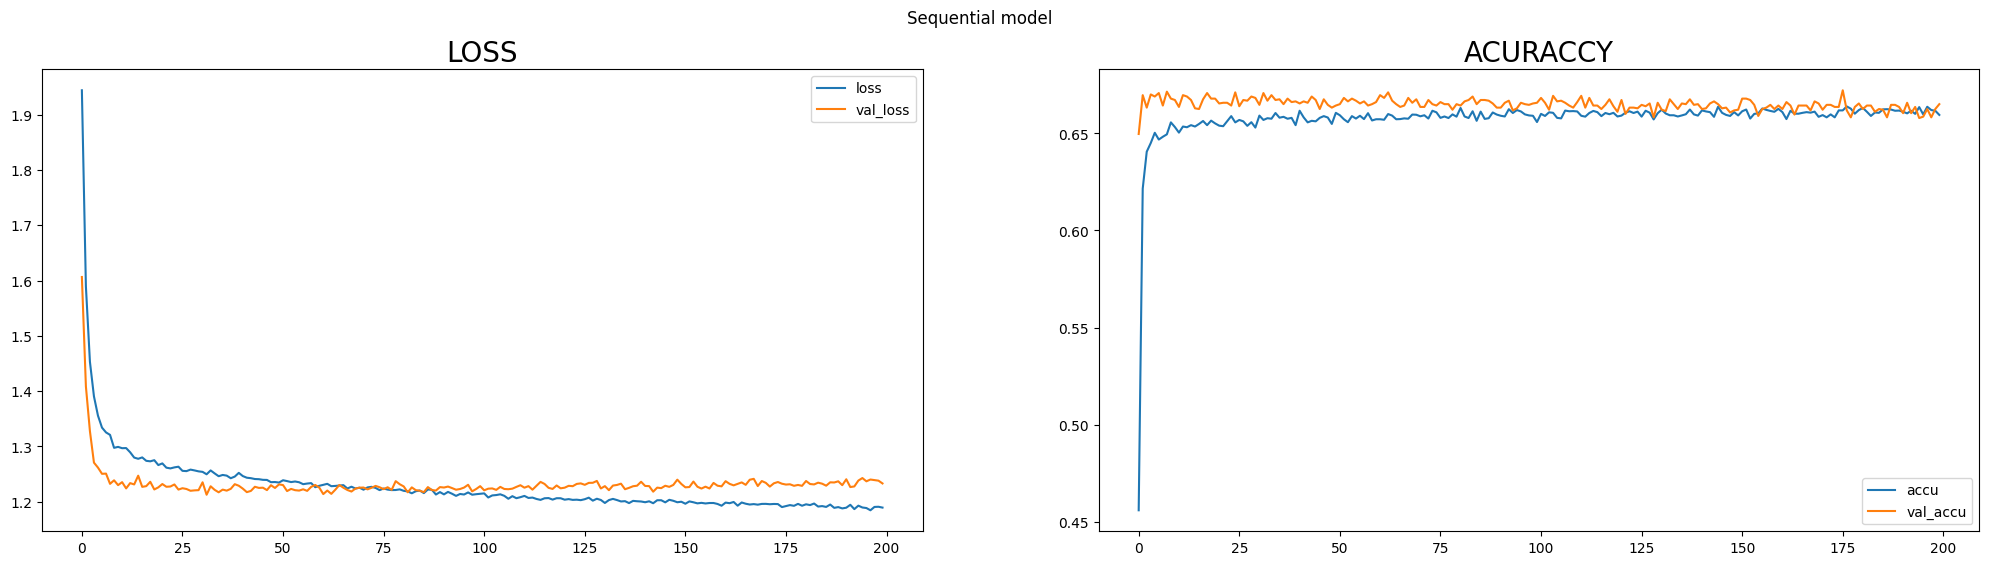

In [14]:
val_loss = reporte.history['loss']
val_accu = reporte.history['accuracy']

val_val_loss = reporte.history['val_loss']
val_val_accu = reporte.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,6))
fig.suptitle('Sequential model')
ax1.plot(val_loss,label='loss')
ax1.plot(val_val_loss,label='val_loss')
ax1.set_title('LOSS',fontsize=20)
ax1.legend()
ax2.plot(val_accu,label='accu')
ax2.plot(val_val_accu,label='val_accu')
ax2.set_title('ACURACCY',fontsize=20)
ax2.legend()

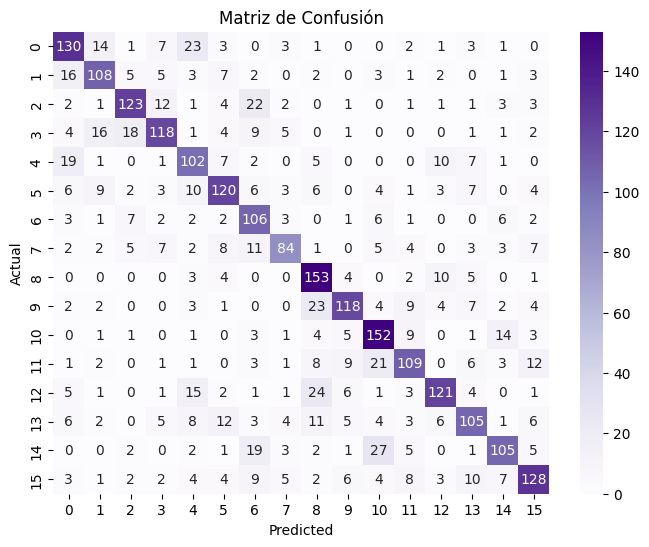

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener las predicciones del modelo
pred_y = probabilidades_prediccion

# Obtener la matriz de confusión
cm = confusion_matrix(np.argmax(test_y, axis=1), np.argmax(pred_y, axis=1))

plt.figure(figsize=(8, 6))

# Visualizar la matriz de confusión utilizando Seaborn y Matplotlib
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', xticklabels=np.unique(np.argmax(test_y, axis=1)), yticklabels=np.unique(np.argmax(test_y, axis=1)))

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [17]:
pred_y_num = []
test_y_num = []

for i in pred_y:
  pred_y_num.append(np.argmax(i)) #Aqui se convierte el valor predicho de binario a valor decimal

for j in test_y:
  test_y_num.append(np.argmax(j)) #Aqui se convierte el valor de test de binario a valor decimal

error=0
for i in range(len(test_y_num)):
        if pred_y_num[i] == test_y_num[i]:
            error += 1

porcentaje= (error /len(test_y_num))*100
print("El porcentaje de acierto de los datos predichos con respecto a los datos de test es %",porcentaje)

El porcentaje de acierto de los datos predichos con respecto a los datos de test es % 67.21428571428572


### Ahora vamos a predecir las etiquetas con un nuevo dataset de prueba despues de haber entrenado el modelo.

In [18]:
prueba = pd.read_csv('https://drive.google.com/uc?id=1UXIp0elFRHH1Ex4kpj9V426piA3nolgK',sep=',',  index_col=False)
prueba = prueba.reset_index(drop=True)
df_validation = pd.DataFrame(prueba)
print(df_validation)

x_validation = df_validation.iloc[:, 1:3]
x_validation

y_validation = df_validation.iloc[:,3]

      SNR  Parte Real  Parte Imaginaria  Mapeo
0     -10   -7.944008          5.832886      2
1     -10    7.040362         -2.628155     10
2     -10  -10.294168         -2.388406      1
3     -10    8.016589         -8.125525      4
4     -10   -9.012413         -0.027449      7
...   ...         ...               ...    ...
7051   20   -2.935141          2.621335      2
7052   20   -1.216238         -3.201692      4
7053   20    1.141582         -0.840337     13
7054   20   -2.954177          1.001278      3
7055   20    2.849009          2.749002     10

[7056 rows x 4 columns]


In [19]:
scaler = StandardScaler()
x_validation_norm_ = scaler.fit_transform(x_validation)

In [20]:
# Realizar la predicción de las etiquetas con los datos de validación
pred_y = model.predict(x_validation_norm_)

# Convertir las predicciones a índices de clase
pred_y_num = np.argmax(pred_y, axis=1)

# Contar los aciertos
aciertos = np.sum(pred_y_num == y_validation)

# Calcular el porcentaje de acierto
porcentaje = (aciertos / len(pred_y_num)) * 100
print("Porcentaje de acierto (%):", porcentaje)

221/221 [==============================] - 0s 2ms/step
Porcentaje de acierto (%): 45.98922902494331


In [21]:
pred_y_num[7000:7005]

array([0, 9, 8, 1, 7])

In [22]:
y_validation[7000:7005]

7000    0
7001    9
7002    8
7003    1
7004    7
Name: Mapeo, dtype: int64

## SVM




In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x_norm, y_new, test_size=0.20,random_state=147)
t_train = np.argmax(train_y, axis = 1) #Etiqutas de entrenamiento
t_test = np.argmax(test_y, axis = 1)   #Etiquetas de prueba

In [24]:
from sklearn.decomposition import PCA, KernelPCA
#Fase 1 
kernel_pca = KernelPCA(n_components=2, kernel="rbf", gamma=20)
train_x = kernel_pca.fit(train_x).transform(train_x)
test_x = kernel_pca.transform(test_x)  #Se garantiza que los datos de prueba estén en el mismo espacio de características que los datos de entrenamiento.

#Fase 2a 
kernel_pca = KernelPCA(n_components=2, kernel="rbf", gamma=10)
train_x_2a = kernel_pca.fit(train_x).transform(train_x)
test_x_2a = kernel_pca.transform(test_x)

#Fase 2b 
kernel_pca = KernelPCA(n_components=2, kernel="cosine", gamma=10)
train_x_2b = kernel_pca.fit(train_x).transform(train_x)
test_x_2b = kernel_pca.transform(test_x)

In [25]:
train_x = np.concatenate((train_x_2a,train_x_2b),axis =1)
test_x = np.concatenate((test_x_2a,test_x_2b),axis =1)

#### Visualización de los datos de prueba

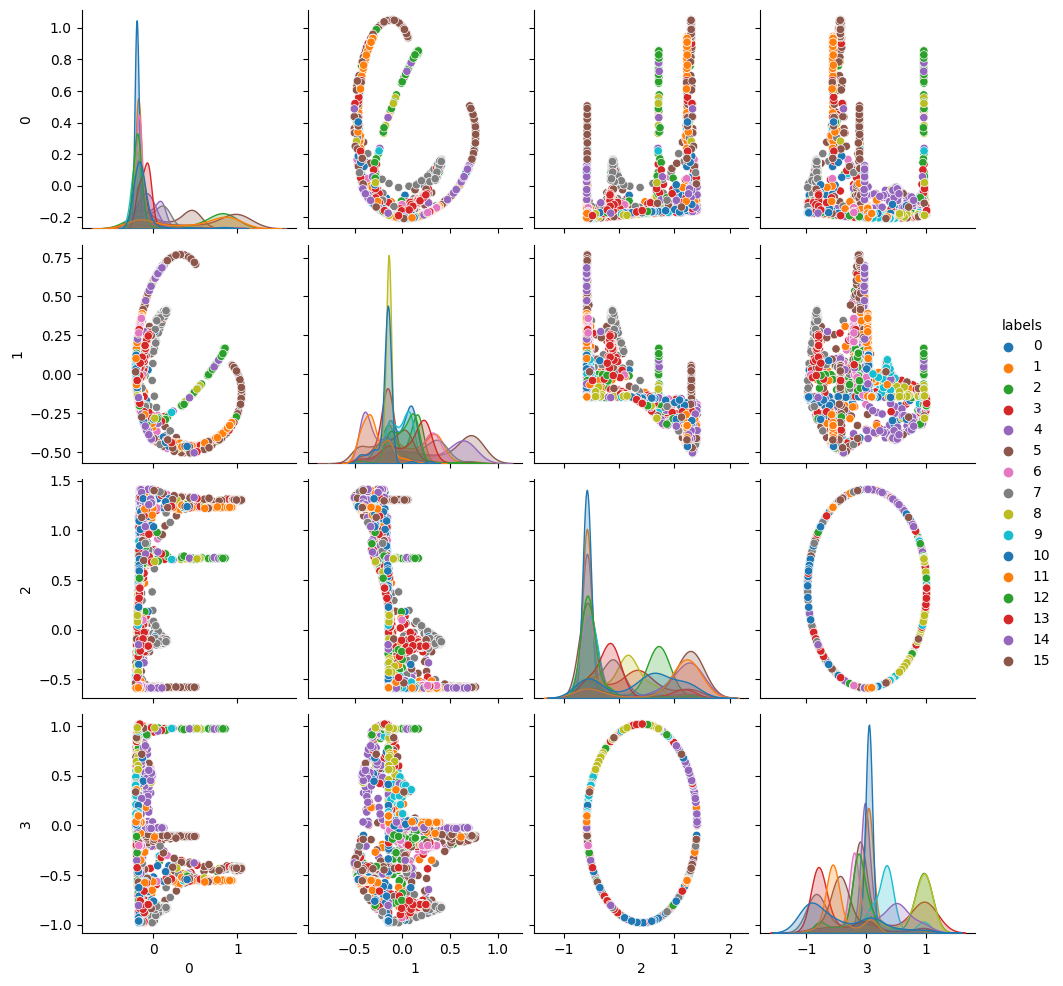

In [26]:
import seaborn as sns
dataFramePCA= pd.DataFrame(test_x)
dataFramePCA['labels'] = t_test  #Etiquetas
sns.pairplot(dataFramePCA, hue='labels', palette= 'tab10')

In [31]:
# defining parameter range
param_grid = {'C': [0.1 ,1, 10,100], #10,100, 1000]
              'gamma': [2, 0.7, 0.1, 0.001],#0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(train_x, t_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.512 total time=   4.6s
[CV 2/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.558 total time=   5.1s
[CV 3/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.525 total time=   4.7s
[CV 4/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.525 total time=   3.7s
[CV 5/5] END ........C=0.1, gamma=2, kernel=rbf;, score=0.540 total time=   4.0s
[CV 1/5] END ......C=0.1, gamma=0.7, kernel=rbf;, score=0.509 total time=   5.9s
[CV 2/5] END ......C=0.1, gamma=0.7, kernel=rbf;, score=0.549 total time=   4.0s
[CV 3/5] END ......C=0.1, gamma=0.7, kernel=rbf;, score=0.520 total time=   3.9s
[CV 4/5] END ......C=0.1, gamma=0.7, kernel=rbf;, score=0.517 total time=   6.0s
[CV 5/5] END ......C=0.1, gamma=0.7, kernel=rbf;, score=0.529 total time=   3.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.347 total time=   4.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;

In [28]:
from sklearn.metrics import accuracy_score
# Hacer predicciones en datos de prueba
predictions = grid.best_estimator_.predict(test_x)

# Evaluar el rendimiento del modelo en datos de prueba
accuracy = accuracy_score(t_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.5707142857142857


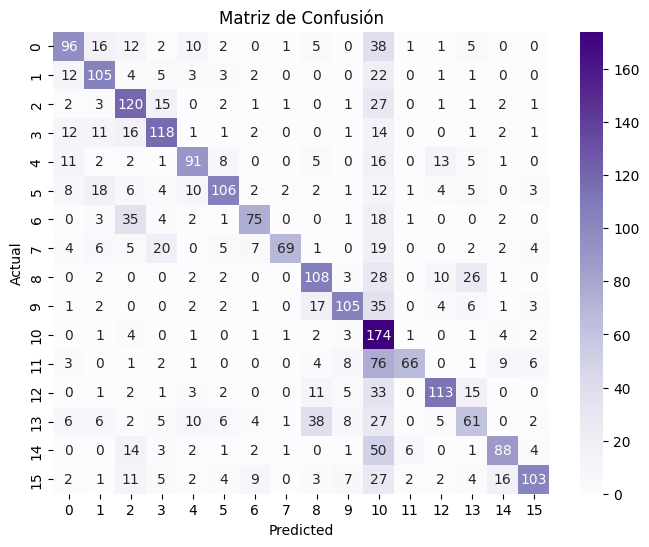

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
cm = confusion_matrix(t_test, predictions)

# Configurar el tamaño de la figura
plt.figure(figsize=(8, 6))

# Visualizar la matriz de confusión utilizando Matplotlib
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', xticklabels=np.unique(t_test), yticklabels=np.unique(t_test))

# Ajustar las etiquetas de los ejes
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

# Mostrar la matriz de confusión
plt.show()